In [101]:
# Step 1: Load the Necessary Libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, FunctionTransformer
import pandas as pd
import numpy as np

# Prepare data

## Load data

In [102]:
# Load the dataset
df = pd.read_csv("../data/raw/Chocolate Sales.csv")

# Display the first few rows
df.head()

,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,04-Jan-22,"$5,320",180
1,Van Tuxwell,India,85% Dark Bars,01-Aug-22,"$7,896",94
2,Gigi Bohling,India,Peanut Butter Cubes,07-Jul-22,"$4,501",91
3,Jan Morforth,Australia,Peanut Butter Cubes,27-Apr-22,"$12,726",342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,24-Feb-22,"$13,685",184


In [81]:
df.shape

(1094, 6)

## Convert to datetime and cleanr the amoutn values

In [103]:
# Convert 'Date' Column to Datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')  # Adjust format if needed
print("\nUpdated Data Types:")
print(df.dtypes)


Updated Data Types:
Sales Person             object
Country                  object
Product                  object
Date             datetime64[ns]
Amount                   object
Boxes Shipped             int64
dtype: object


In [104]:
df['Amount'] = df['Amount'].replace('[\$,]', '', regex=True).astype(float)  # Convert Amount to numeric
print("\nUpdated Data Types:")
print(df.dtypes)


Updated Data Types:
Sales Person             object
Country                  object
Product                  object
Date             datetime64[ns]
Amount                  float64
Boxes Shipped             int64
dtype: object


## Order By date

In [93]:
df = df.sort_values(by="Date")  # Replace with actual date column name
df.head()

,Sales Person,Country,Product,Date,Amount,Boxes Shipped
253,Marney O'Breen,Australia,Smooth Sliky Salty,2022-01-03,3745.0,170
89,Andria Kimpton,Canada,Caramel Stuffed Bars,2022-01-03,7154.0,348
398,Marney O'Breen,Canada,Spicy Special Slims,2022-01-03,3528.0,336
428,Ches Bonnell,UK,White Choc,2022-01-03,3269.0,226
187,Dotty Strutley,UK,99% Dark & Pure,2022-01-03,9310.0,282


# Check amoutn of data 

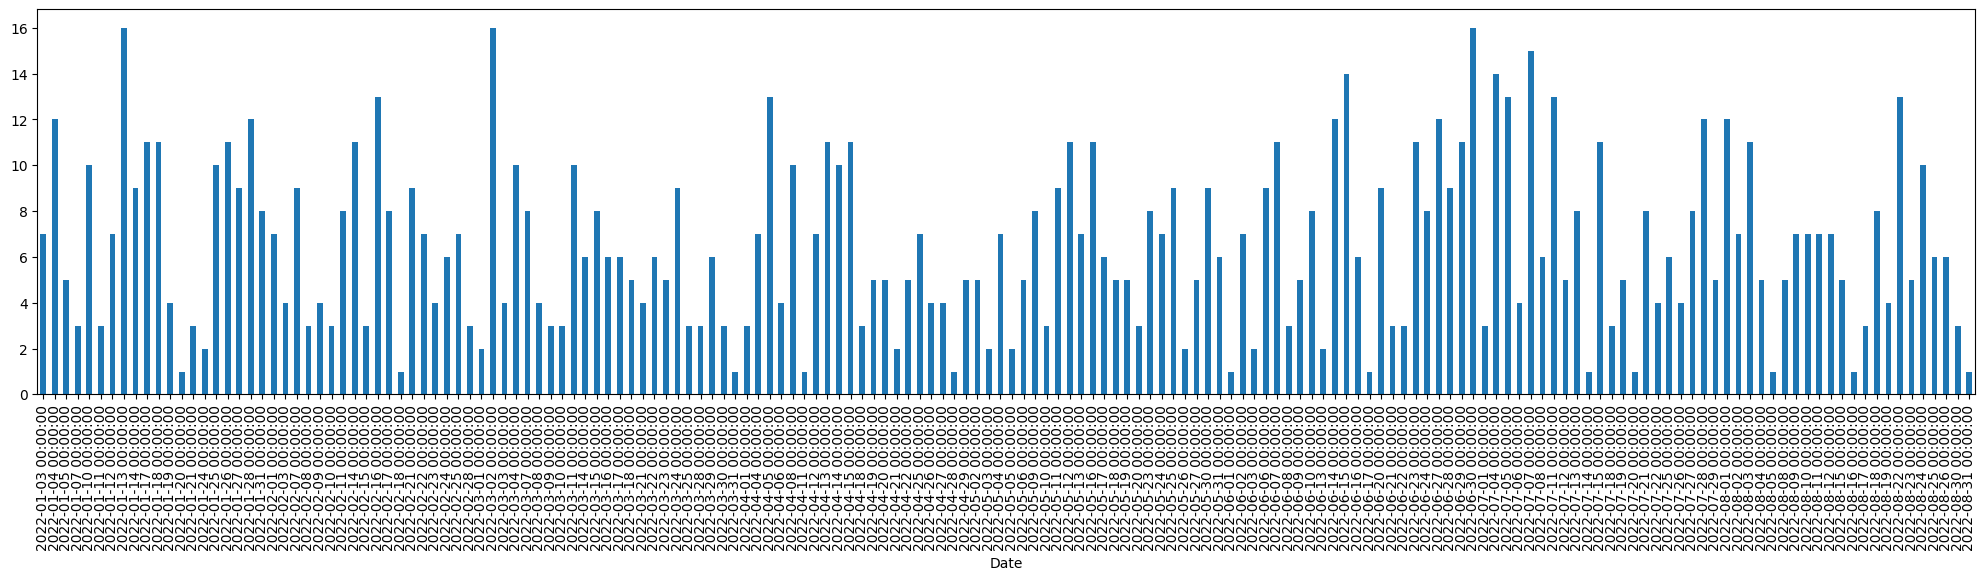

In [85]:
plt.figure(figsize=(25, 5))  # Adjust width (15) and height (5) as needed
df.groupby("Date").size().plot(kind="bar")
plt.show()

In [86]:
df.groupby(["Country", "Product"]).size().describe()

count    132.000000
mean       8.287879
std        2.397614
min        3.000000
25%        6.000000
50%        8.000000
75%       10.000000
max       16.000000
dtype: float64

## Conclusion 

Since the amoutn of data is not enoughm there are date withoit sales and the amoutn of data for each combination of country and product is small a RNN model will struggle with such sparce data.

So we will proceed to use SARIMAX and group by total sales by country 

# Create Pipeline

In [95]:
df

,Sales Person,Country,Product,Date,Amount,Boxes Shipped
253,Marney O'Breen,Australia,Smooth Sliky Salty,2022-01-03,3745.0,170
89,Andria Kimpton,Canada,Caramel Stuffed Bars,2022-01-03,7154.0,348
398,Marney O'Breen,Canada,Spicy Special Slims,2022-01-03,3528.0,336
428,Ches Bonnell,UK,White Choc,2022-01-03,3269.0,226
187,Dotty Strutley,UK,99% Dark & Pure,2022-01-03,9310.0,282
...,...,...,...,...,...,...
74,Van Tuxwell,UK,Organic Choco Syrup,2022-08-26,2002.0,214
777,Husein Augar,UK,Eclairs,2022-08-30,1750.0,252
973,Jehu Rudeforth,India,Almond Choco,2022-08-30,10122.0,100
304,Beverie Moffet,New Zealand,85% Dark Bars,2022-08-30,11200.0,22


In [114]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Aggregate Sales by Country & Date
def aggregate_sales(df):
    df = df.drop(columns=["Sales Person"], errors="ignore")  # Drop unnecessary columns
    df["Date"] = pd.to_datetime(df["Date"])  # Ensure datetime format

    df_agg = df.groupby(["Date", "Country", "Product"]).agg({
        "Amount": "sum",  
        "Boxes Shipped": "sum"  
    }).reset_index()
    
    return df_agg

#  Fill Missing Dates for Each Country
def fill_missing_dates(df):
    date_range = pd.date_range(start=df["Date"].min(), end=df["Date"].max())
    countries = df["Country"].unique()
    products = df["Product"].unique()

    df_full = pd.MultiIndex.from_product(
        [date_range, countries, products], names=["Date", "Country", "Product"]
    ).to_frame(index=False)

    df_full = df_full.merge(df, on=["Date", "Country", "Product"], how="left").fillna(0)
    return df_full

#  Add Date Features
def add_date_features(df):
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df["DayOfWeek"] = df["Date"].dt.dayofweek
    return df.drop(columns=["Date"])

#  Encode Cyclic Features
def encode_cyclic_features(df):
    df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
    df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)
    df["DayOfWeek_sin"] = np.sin(2 * np.pi * df["DayOfWeek"] / 7)
    df["DayOfWeek_cos"] = np.cos(2 * np.pi * df["DayOfWeek"] / 7)
    return df


#  Define Column Transformers
categorical_features = ["Country", "Product"]
numerical_features = ["Amount", "Boxes Shipped", "Year", "Month", "Day", "DayOfWeek"]

preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("scaler", StandardScaler(), numerical_features)
])


In [115]:
df.head(3)

,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,5320.0,180
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,7896.0,94
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,4501.0,91


In [116]:
df_agg = aggregate_sales(df)
df_agg.head(3)

,Date,Country,Product,Amount,Boxes Shipped
0,2022-01-03,Australia,Smooth Sliky Salty,3745.0,170
1,2022-01-03,Canada,Caramel Stuffed Bars,7154.0,348
2,2022-01-03,Canada,Spicy Special Slims,3528.0,336


In [117]:
df_all_dates = fill_missing_dates(df_agg)
df_all_dates.head()

,Date,Country,Product,Amount,Boxes Shipped
0,2022-01-03,Australia,Smooth Sliky Salty,3745.0,170.0
1,2022-01-03,Australia,Caramel Stuffed Bars,0.0,0.0
2,2022-01-03,Australia,Spicy Special Slims,0.0,0.0
3,2022-01-03,Australia,99% Dark & Pure,0.0,0.0
4,2022-01-03,Australia,White Choc,0.0,0.0


In [118]:
df_all_features = add_date_features(df_all_dates)
df_all_features.head()

,Country,Product,Amount,Boxes Shipped,Year,Month,Day,DayOfWeek
0,Australia,Smooth Sliky Salty,3745.0,170.0,2022,1,3,0
1,Australia,Caramel Stuffed Bars,0.0,0.0,2022,1,3,0
2,Australia,Spicy Special Slims,0.0,0.0,2022,1,3,0
3,Australia,99% Dark & Pure,0.0,0.0,2022,1,3,0
4,Australia,White Choc,0.0,0.0,2022,1,3,0


In [123]:
# Fit the preprocessor only (without transforming)
preprocessor.fit(df_all_features)

# Get feature names
feature_names = preprocessor.get_feature_names_out(input_features=categorical_features + numerical_features)

# Display feature names
print(feature_names)

['onehot__Country_Australia' 'onehot__Country_Canada'
 'onehot__Country_India' 'onehot__Country_New Zealand'
 'onehot__Country_UK' 'onehot__Country_USA'
 'onehot__Product_50% Dark Bites' 'onehot__Product_70% Dark Bites'
 'onehot__Product_85% Dark Bars' 'onehot__Product_99% Dark & Pure'
 'onehot__Product_After Nines' 'onehot__Product_Almond Choco'
 "onehot__Product_Baker's Choco Chips"
 'onehot__Product_Caramel Stuffed Bars'
 'onehot__Product_Choco Coated Almonds' 'onehot__Product_Drinking Coco'
 'onehot__Product_Eclairs' 'onehot__Product_Fruit & Nut Bars'
 'onehot__Product_Manuka Honey Choco' 'onehot__Product_Milk Bars'
 'onehot__Product_Mint Chip Choco' 'onehot__Product_Orange Choco'
 'onehot__Product_Organic Choco Syrup'
 'onehot__Product_Peanut Butter Cubes' 'onehot__Product_Raspberry Choco'
 'onehot__Product_Smooth Sliky Salty'
 'onehot__Product_Spicy Special Slims' 'onehot__Product_White Choc'
 'scaler__Amount' 'scaler__Boxes Shipped' 'scaler__Year' 'scaler__Month'
 'scaler__Day' 

In [127]:
# Transform the data
df_processed = preprocessor.transform(df_all_features)
print(df_processed.shape)  # Expected: (31812, 34)
print((feature_names))  # Expected: 34

# Convert to DataFrame
df_processed = pd.DataFrame(df_processed.toarray(), columns=feature_names)

(31812, 34)
['onehot__Country_Australia' 'onehot__Country_Canada'
 'onehot__Country_India' 'onehot__Country_New Zealand'
 'onehot__Country_UK' 'onehot__Country_USA'
 'onehot__Product_50% Dark Bites' 'onehot__Product_70% Dark Bites'
 'onehot__Product_85% Dark Bars' 'onehot__Product_99% Dark & Pure'
 'onehot__Product_After Nines' 'onehot__Product_Almond Choco'
 "onehot__Product_Baker's Choco Chips"
 'onehot__Product_Caramel Stuffed Bars'
 'onehot__Product_Choco Coated Almonds' 'onehot__Product_Drinking Coco'
 'onehot__Product_Eclairs' 'onehot__Product_Fruit & Nut Bars'
 'onehot__Product_Manuka Honey Choco' 'onehot__Product_Milk Bars'
 'onehot__Product_Mint Chip Choco' 'onehot__Product_Orange Choco'
 'onehot__Product_Organic Choco Syrup'
 'onehot__Product_Peanut Butter Cubes' 'onehot__Product_Raspberry Choco'
 'onehot__Product_Smooth Sliky Salty'
 'onehot__Product_Spicy Special Slims' 'onehot__Product_White Choc'
 'scaler__Amount' 'scaler__Boxes Shipped' 'scaler__Year' 'scaler__Month'
 's

In [128]:
df_processed.head()

,onehot__Country_Australia,onehot__Country_Canada,onehot__Country_India,onehot__Country_New Zealand,onehot__Country_UK,onehot__Country_USA,onehot__Product_50% Dark Bites,onehot__Product_70% Dark Bites,onehot__Product_85% Dark Bars,onehot__Product_99% Dark & Pure,...,onehot__Product_Raspberry Choco,onehot__Product_Smooth Sliky Salty,onehot__Product_Spicy Special Slims,onehot__Product_White Choc,scaler__Amount,scaler__Boxes Shipped,scaler__Year,scaler__Month,scaler__Day,scaler__DayOfWeek
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2.732031,4.356151,0.0,-1.557991,-1.468519,-1.486126
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.149566,-0.147403,0.0,-1.557991,-1.468519,-1.486126
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-0.149566,-0.147403,0.0,-1.557991,-1.468519,-1.486126
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,-0.149566,-0.147403,0.0,-1.557991,-1.468519,-1.486126
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,-0.149566,-0.147403,0.0,-1.557991,-1.468519,-1.486126
